<a href="https://colab.research.google.com/github/Mejayyy/AnomalyDet/blob/main/AD_Lab_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch_geometric
!pip install torch


In [6]:
import numpy as np
import random

import torch
from torch_geometric.nn import GCNConv
from torch_geometric.utils.convert import from_scipy_sparse_matrix
from torch_geometric.utils import subgraph, to_dense_adj
import torch.nn as nn
import torch.nn.functional as F

from numpy.linalg import eigh

from sklearn.metrics import roc_auc_score as ras

from scipy.io import loadmat

import networkx as nx
import matplotlib.pyplot as plt


import torch
from torch.optim import Optimizer
from torch.optim import Adam
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import LocalOutlierFactor
import math


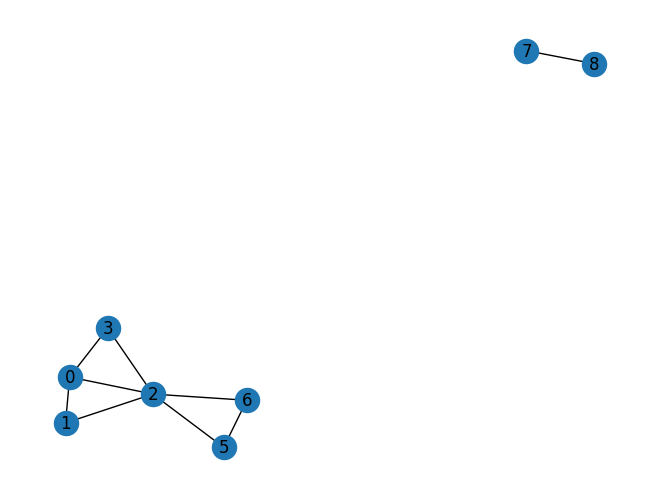

In [3]:
#Ex 1.1
G = nx.Graph()
def init_graph(file,garbage=1):
  G_aux=nx.Graph()

  #First 1500 lines
  k=1
  with open(file, "r") as f:
    if garbage==1:
      for _ in range(4):
            next(f)
    for line in f:
      if k==1500:
        break
      node1_str, node2_str = line.split()
      node1, node2 = int(node1_str), int(node2_str)

      # If the edge already exists, increment its weight
      if G_aux.has_edge(node1, node2):
          G_aux[node1][node2]["weight"] += 1
      else:
          G_aux.add_edge(node1, node2, weight=1)
      k=k+1
    return G_aux

G=init_graph("ca-AstroPh.txt")

#Testing everything on demo
demo=init_graph("demo.txt",0)
nx.draw(demo,with_labels=True)


In [4]:
#Ex 1.2
def compute_egonet_features(G,verb=0):


    # Dictionaries to hold the feature values for each node
    N_dict = {}
    E_dict = {}
    W_dict = {}
    lambda_dict = {}

    for node in G.nodes():


        neighbors = list(G.neighbors(node))
        subgraph_nodes = set([node] + neighbors)
        egonet = G.subgraph(subgraph_nodes)

        #Compute the features

        # N_i: number of neighbors
        N_i = len(neighbors)

        # E_i: number of edges in the egonet
        E_i = egonet.number_of_edges()

        # W_i: sum of weights in the egonet
        W_i = sum(attr["weight"] for _, _, attr in egonet.edges(data=True))

        # lambda_w: principal eigenvalue of the weighted adjacency matrix
        A = nx.to_numpy_array(egonet, nodelist=subgraph_nodes, weight="weight")

        # Compute eigenvalues of A

        eigenvalues = np.linalg.eigvalsh(A)


        # The principal eigenvalue is the largest eigenvalue
        lambda_w = max(eigenvalues) if len(eigenvalues) > 0 else 0.0

        if verb==1:
          print("\nFor node ",node," :\n")
          print("A = \n",A)
          plt.figure(figsize=(4,4))
          nx.draw(egonet,with_labels=True)
          plt.show()
        # Store in dictionaries
        N_dict[node] = N_i
        E_dict[node] = E_i
        W_dict[node] = W_i
        lambda_dict[node] = lambda_w

    # --- 3. Set node attributes in the main graph
    nx.set_node_attributes(G, N_dict,  "N")
    nx.set_node_attributes(G, E_dict,  "E")
    nx.set_node_attributes(G, W_dict,  "W")
    nx.set_node_attributes(G, lambda_dict, "lambda_w")

compute_egonet_features(demo)

print(demo.nodes[0])

print(demo.nodes[0]["N"])
compute_egonet_features(G)
print(len(G.nodes))

{'N': 3, 'E': 5, 'W': 6, 'lambda_w': 3.13263749357984}
3
1103


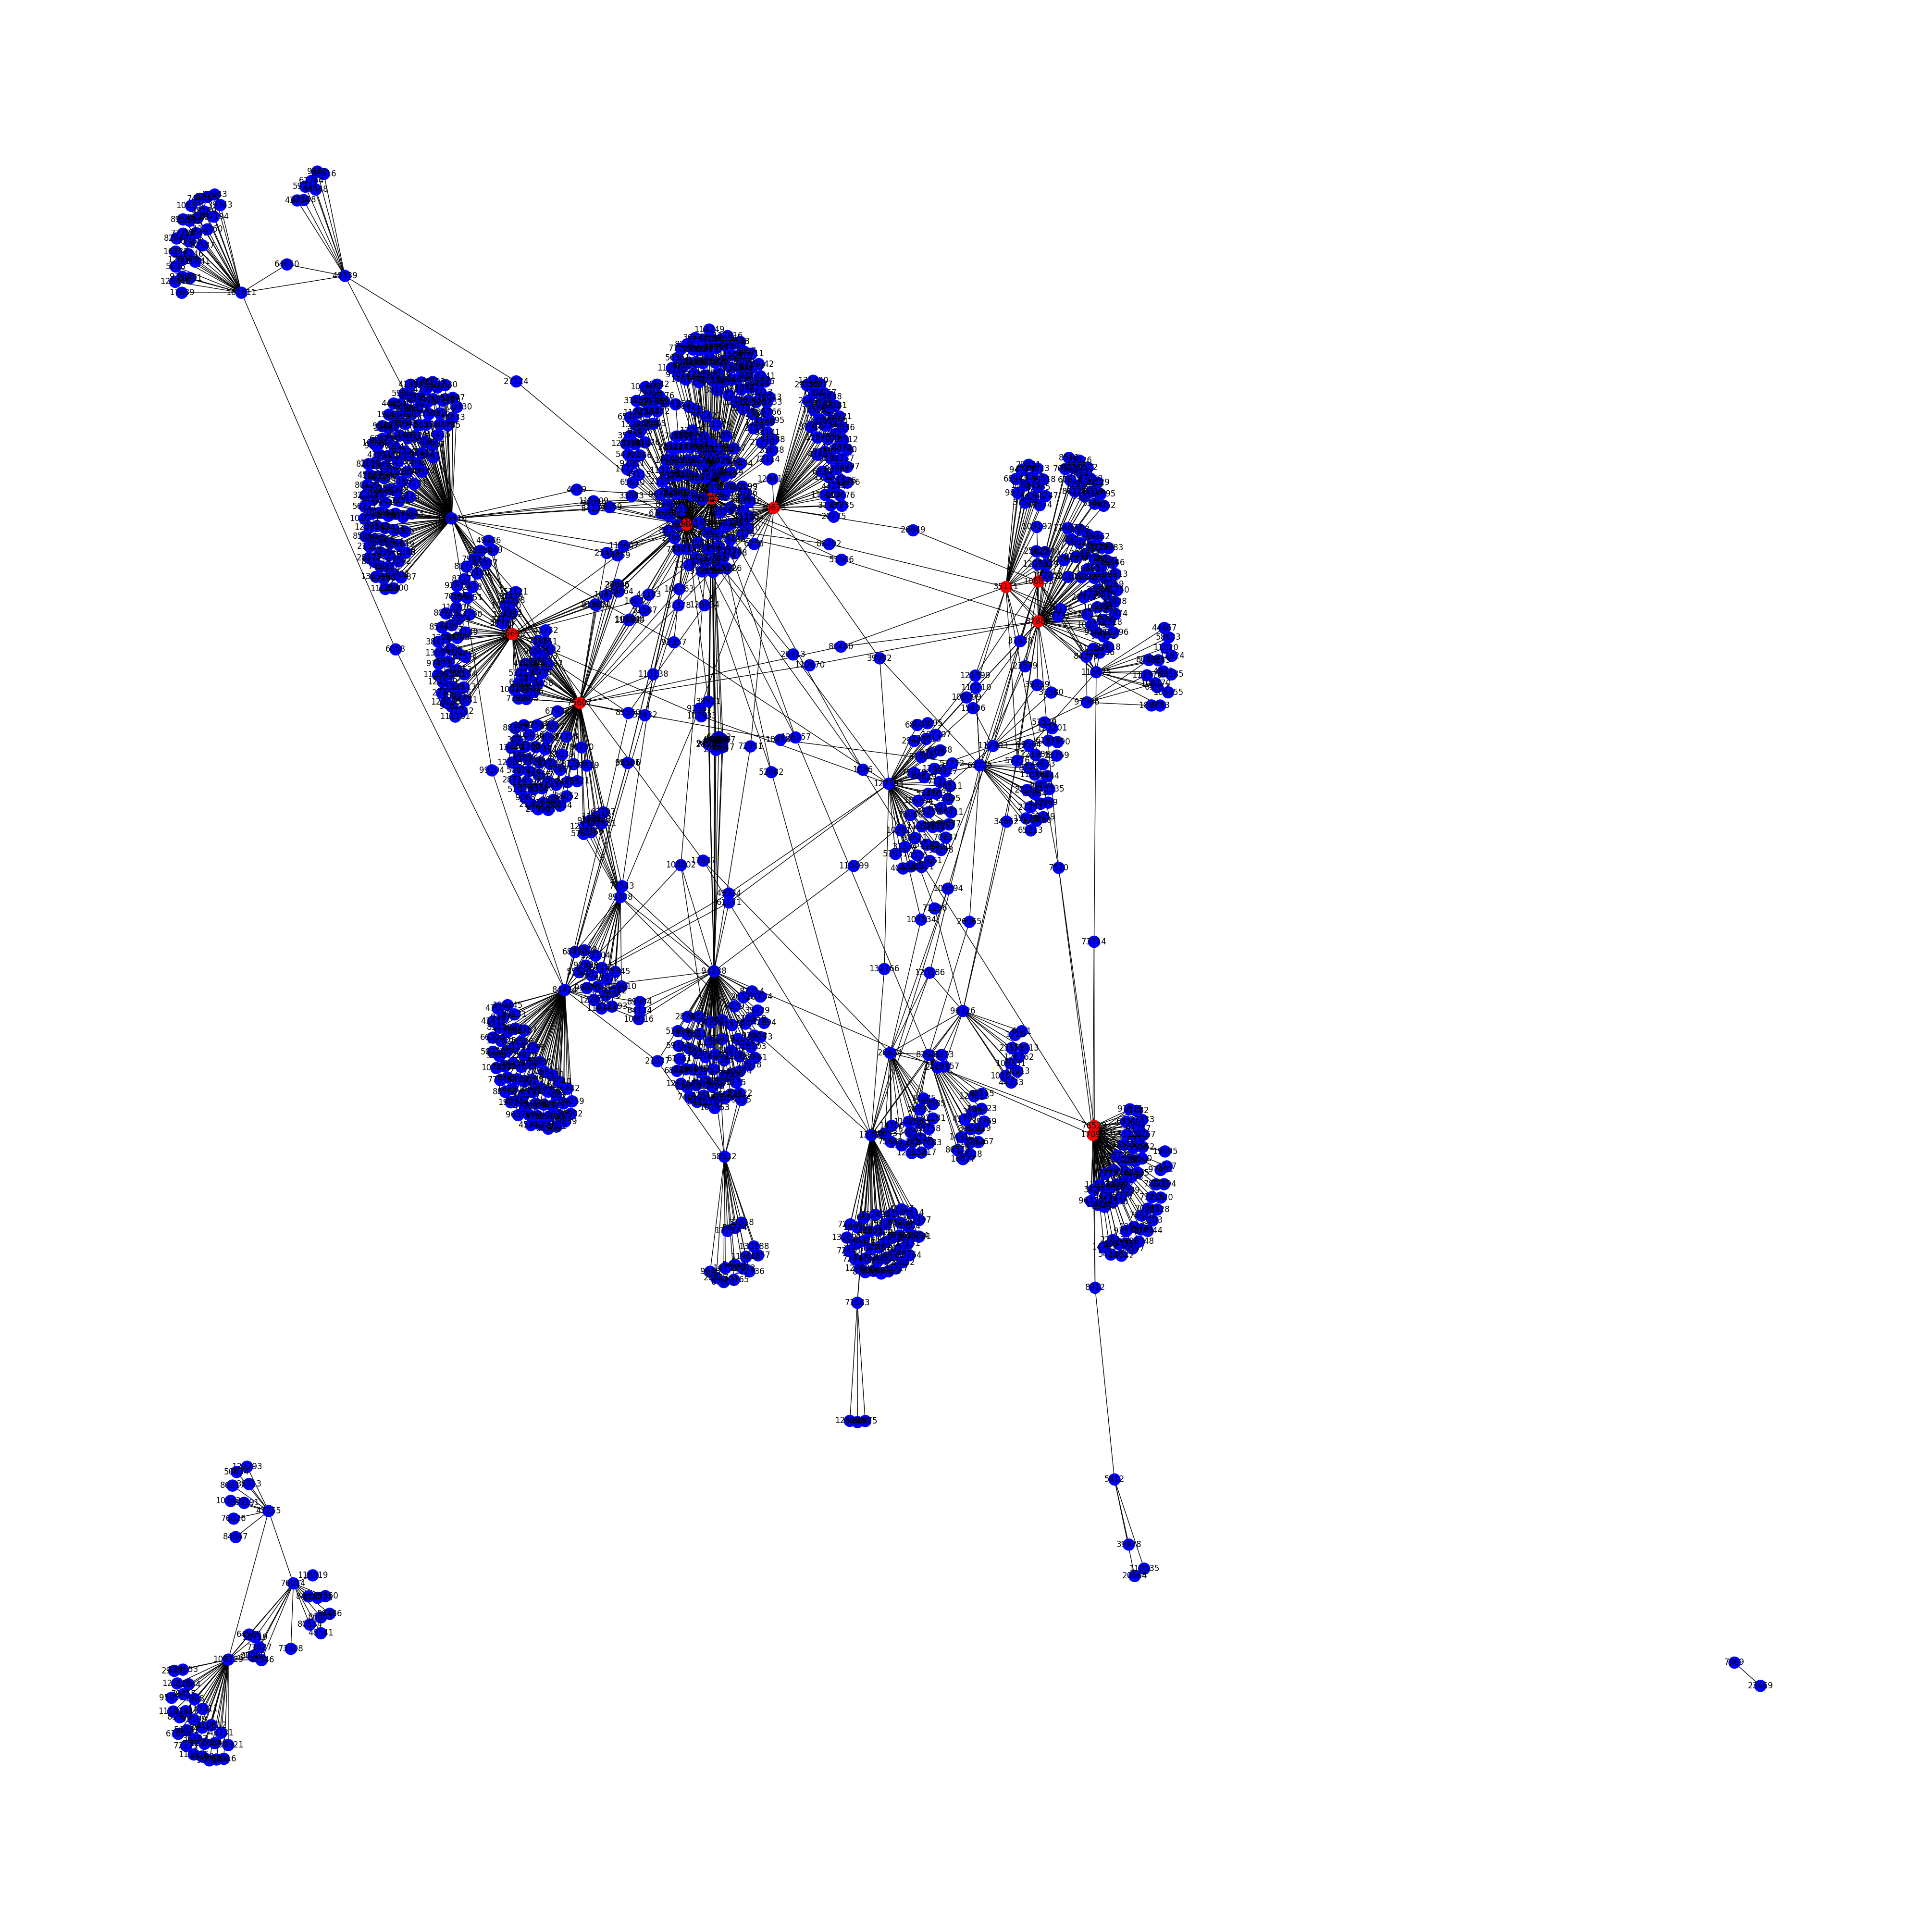

In [17]:
#Ex 1.3-4
def score(node,C,theta,feat1,feat2):
  y=node[feat1]
  x=node[feat2]
  q=max(y,C*(x**theta))
  t=min(y,C*(x**theta))
  logul=math.log(abs(y-C*(x**theta))+1)
  return q*logul/t


def regresie(G=G,feat1="N",feat2="E",nr_outlier=10):
  nodes=list(G.nodes)
  nr_nodes=len(nodes)
  """print(nr_nodes)
  print(nodes)
  print(G.nodes[84424])
  print(G.nodes[nodes[1]])"""
  #Preparing the linear regression

  Reg=np.ones((nr_nodes,2))
  b=np.zeros(nr_nodes)

  for i in range(nr_nodes):
    Reg[i,1]=math.log(G.nodes[nodes[i]][feat1])
    b[i]=math.log(G.nodes[nodes[i]][feat2])

  lin_model=LinearRegression(fit_intercept=False).fit(Reg,b)

  log_C,theta=lin_model.coef_

  #print(log_C,theta)
  C=math.exp(log_C)
  #print(C)



  scores=[]
  for node in G.nodes:
    scores.append(score(node=G.nodes[node],C=C,theta=theta, feat1=feat1, feat2=feat2))



  scores_dict = {nodes[i]: scores[i]  for i in range(nr_nodes)}
  top_10_nodes = sorted(scores_dict, key=scores_dict.get, reverse=True)[:nr_outlier]

  # Color map
  color_map = []
  for node in G.nodes():
      if node in top_10_nodes:
          color_map.append("red")
      else:
          color_map.append("blue")

  # Drawing the anomalous nodes
  plt.figure(figsize=(40, 40))  # set figure size
  nx.draw(G, with_labels=True, node_color=color_map)
  plt.show()

  #need this for ex. 5
  return scores_dict


reg_dict=regresie()

/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(


{84424: 1.7257376, 276: 1.0, 1662: 1.0, 5089: 1.0, 6058: 1.0, 6229: 1.0, 10639: 1.0, 16442: 1.0, 19325: 1.0, 19834: 1.0, 20113: 1.0, 21937: 1531066100.0, 25452: 1.0, 26902: 1.0, 29829: 1.0, 30222: 1.0, 32432: 1.0, 33040: 1.0, 39238: 1.0, 39521: 1.0, 41418: 1.0, 45009: 1.0, 45098: 1.0, 45242: 1.0, 47005: 1.0, 47968: 1.0, 47999: 1.0, 49934: 1.0, 50220: 1.0, 50897: 1.0, 51730: 1.0, 53681: 1.0, 57537: 1.0, 58458: 1.0, 59326: 1.0, 61571: 1.0, 63552: 1.0, 64124: 1.0, 64568: 1.0, 66200: 1.0, 69839: 1.0, 72391: 1.0, 73543: 1.8118069, 76259: 1.0, 77098: 1.0, 77915: 1.0, 78627: 1.0, 83560: 1165685500.0, 85420: 1.0, 88768: 1.0, 89131: 1.0, 89308: 3.05413, 89994: 1.0, 90506: 1.0, 91060: 1.0, 92387: 1.0, 93296: 1.0, 94138: 1.8297697, 94329: 1.0, 95070: 1.0, 95531: 1.0, 96570: 1.0, 97101: 1.0, 98506: 1.0, 99104: 1.0, 104802: 1.0072434, 106611: 1.0, 107829: 1.0, 109016: 1.0, 112605: 1.0, 117751: 1.0, 122908: 1.0, 124023: 1.0, 125190: 1.0, 130825: 1.0, 132445: 1.0, 560: 1.0, 15829: 1.0, 42972: 1.0, 55

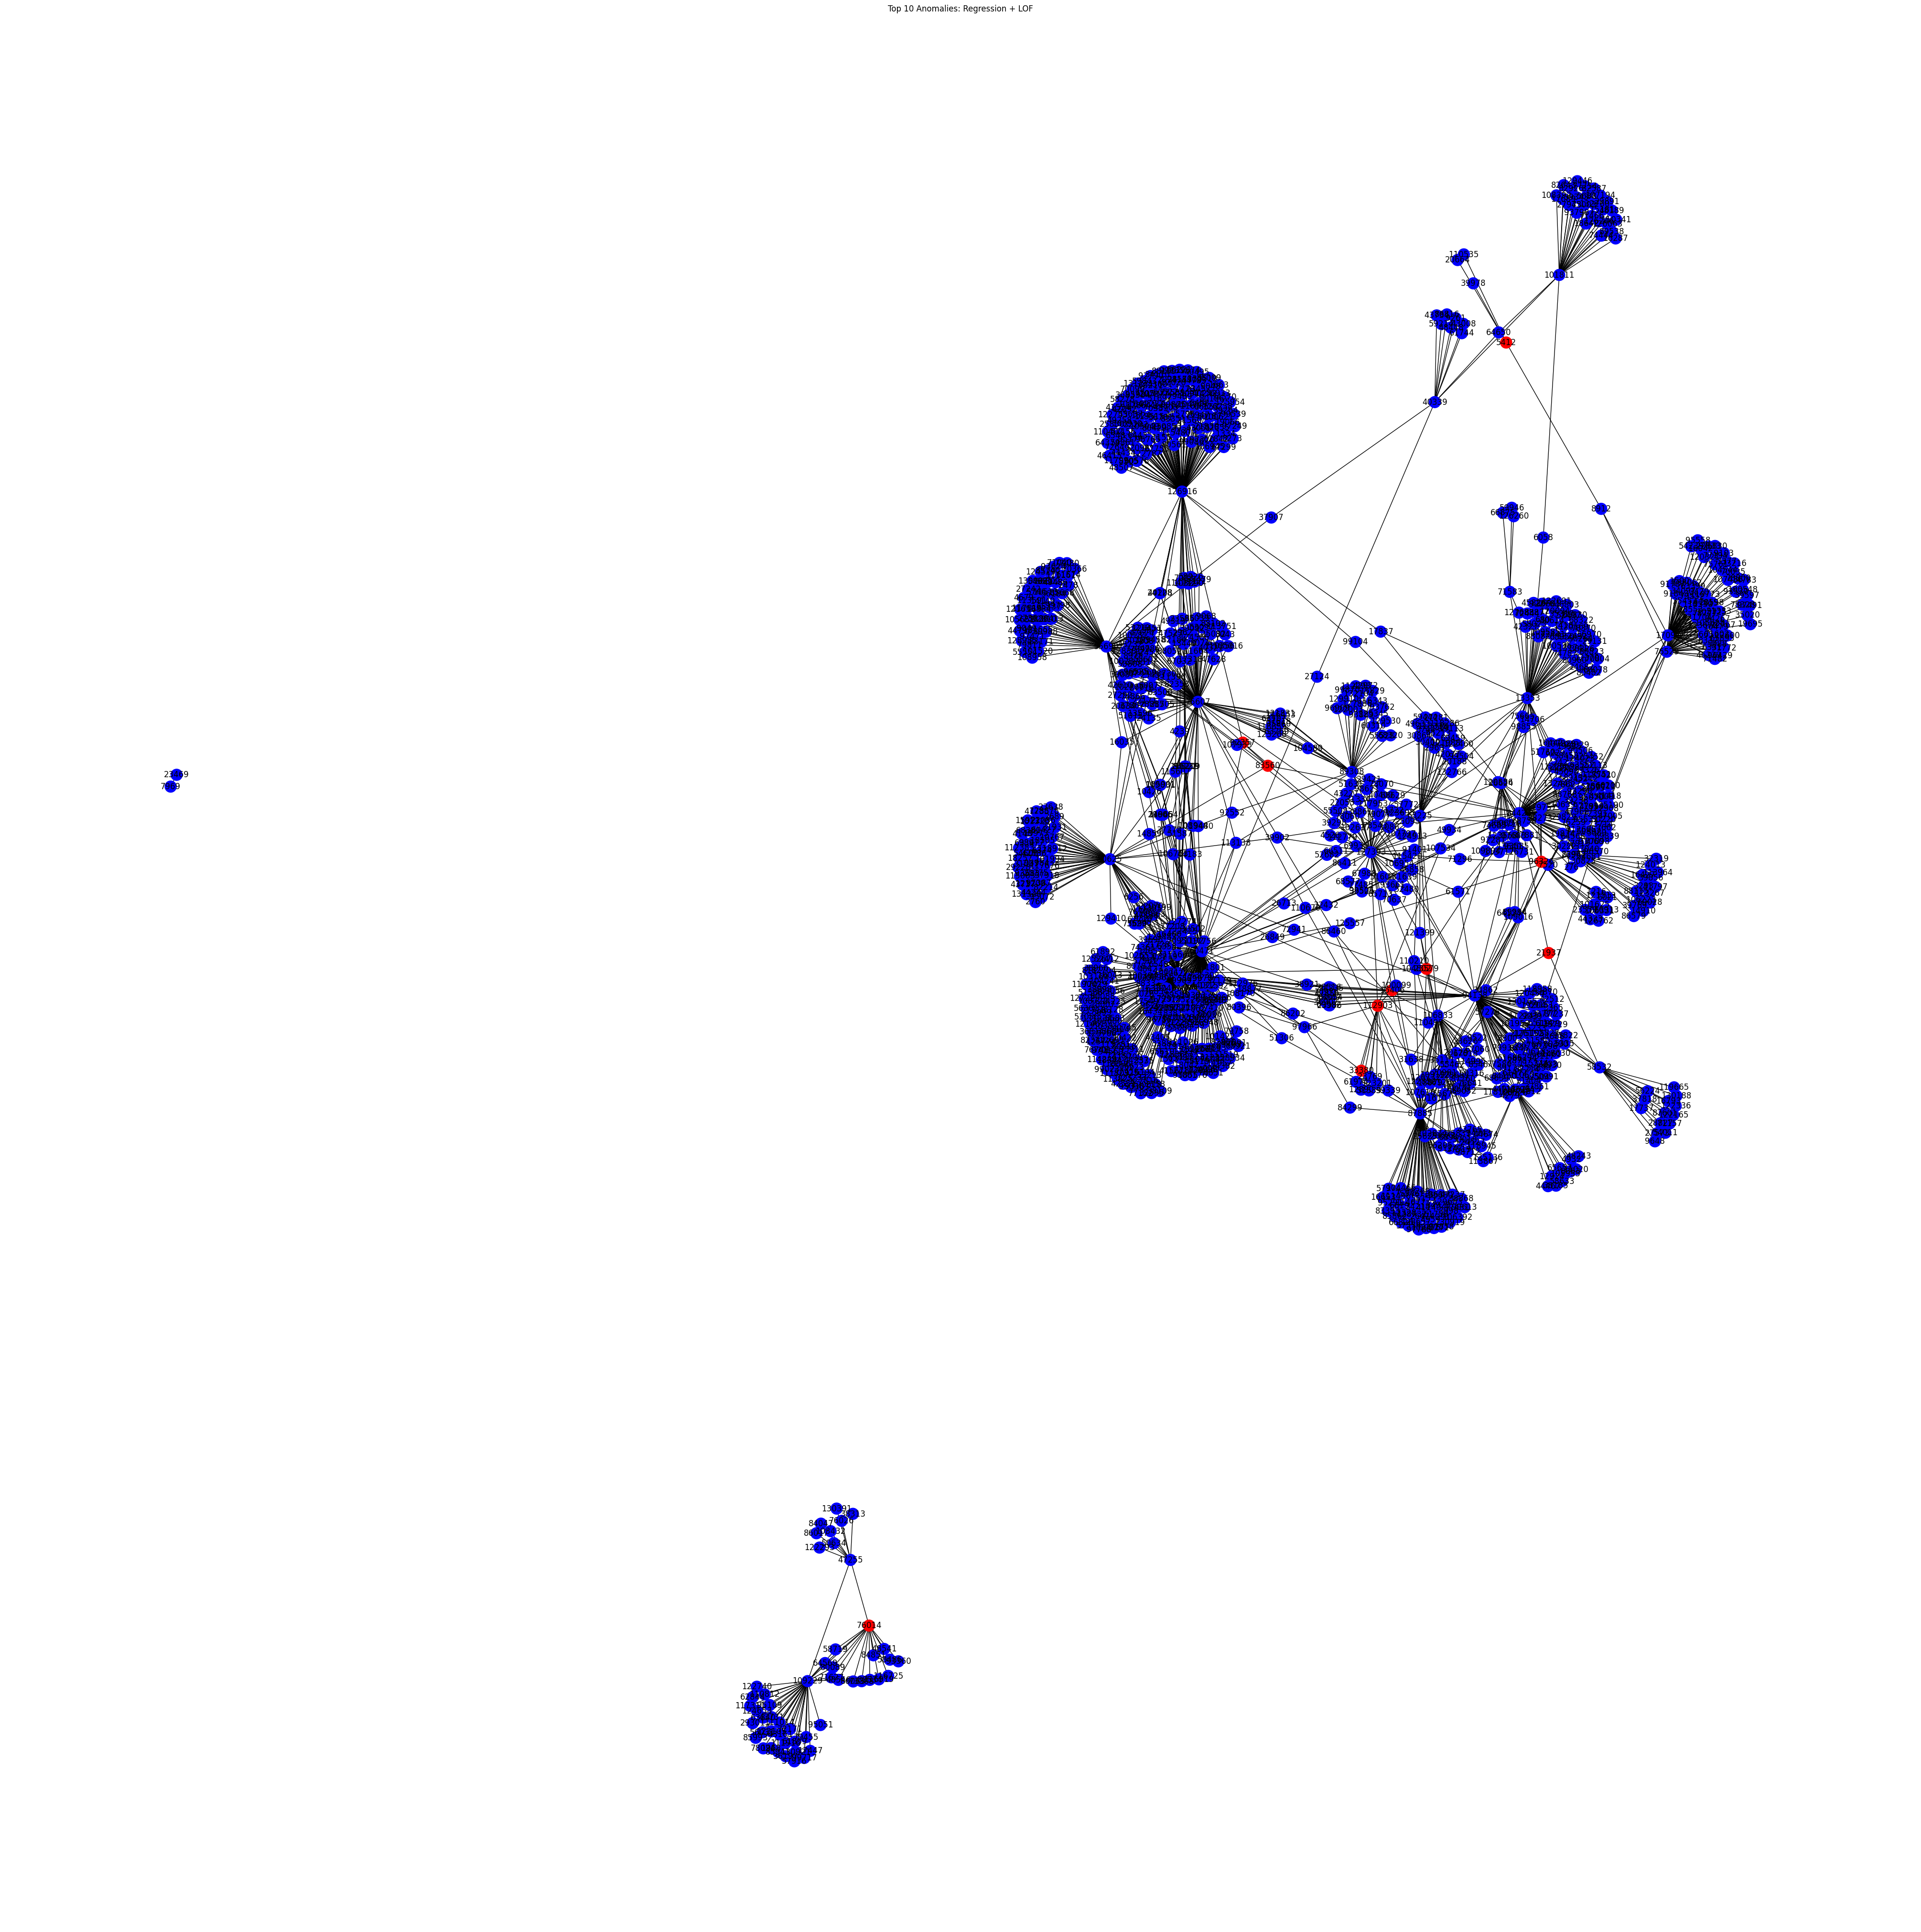

In [20]:
#Ex 1.5
def lof_scores(G=G, feat1="N", feat2="E", n_neighbors=20):

    nodes = list(G.nodes)
    nr_nodes = len(nodes)

    # Build an array X with columns = [feat1, feat2]
    X = np.zeros((nr_nodes, 2), dtype=np.float32)
    for i, node_id in enumerate(nodes):
        X[i, 0] = G.nodes[node_id][feat1]
        X[i, 1] = G.nodes[node_id][feat2]

    # Fit LOF
    lof = LocalOutlierFactor(n_neighbors=n_neighbors, metric='euclidean')
    lof.fit_predict(X)  # We only need negative_outlier_factor_

    # lof.negative_outlier_factor_ is shape (nr_nodes, )
    # More negative => more outlier
    negative_of = lof.negative_outlier_factor_

    # We'll define a positive anomaly score => higher => more outlier
    scores = -negative_of  # multiply by -1
    # Make a dict
    lof_dict = {}
    for i, node in enumerate(nodes):
        lof_dict[node] = scores[i]

    return lof_dict

lof_dict=lof_scores()

print(lof_dict)
print(reg_scores)

def combine_scores(reg_dict, lof_dict):
    """
    Combine the regression-based score (normalized) + LOF score into a final score.
    Returns a dict {node: combined_score}.
    """
    # 1) Min-max normalize the regression-based scores
    vals = list(reg_dict.values())
    min_val = min(vals)
    max_val = max(vals)
    range_val = max_val - min_val if max_val != min_val else 1e-8

    norm_reg_scores = {}
    for n, sc in reg_dict.items():
        norm_reg_scores[n] = (sc - min_val) / range_val

    # 2) Add the LOF score
    combined = {}
    for node in reg_dict:
        combined[node] = norm_reg_scores[node] + lof_dict[node]

    return combined

final_score=combine_scores(reg_dict,lof_dict)

def reg_lof_anomalies(G=G, feat1="N", feat2="E", n_neighbors=20, nr_outlier=10):
    """    # 1) If you haven't computed the (N, E) features, do it now,
    #    but presumably you already did in a previous step (OddBall).
    #    So let's assume each node has G.nodes[node]["N"] and ["E"].

    # 2) Regression-based scores
    reg_scores = regression_scores(G, feat1, feat2)

    # 3) LOF scores
    lof_dict = lof_scores(G, feat1, feat2, n_neighbors=n_neighbors)

    # 4) Combine them"""


    # 5) Sort and pick the top 10 anomalies
    top_10_nodes = sorted(final_score, key=final_score.get, reverse=True)[:nr_outlier]

    # 6) Color map for the top-10 anomalies
    color_map = []
    for node in G.nodes():
        if node in top_10_nodes:
            color_map.append("red")
        else:
            color_map.append("blue")

    plt.figure(figsize=(40, 40))
    nx.draw(G, with_labels=True, node_color=color_map)
    plt.title(f"Top {nr_outlier} Anomalies: Regression + LOF")
    plt.show()


reg_lof_anomalies()

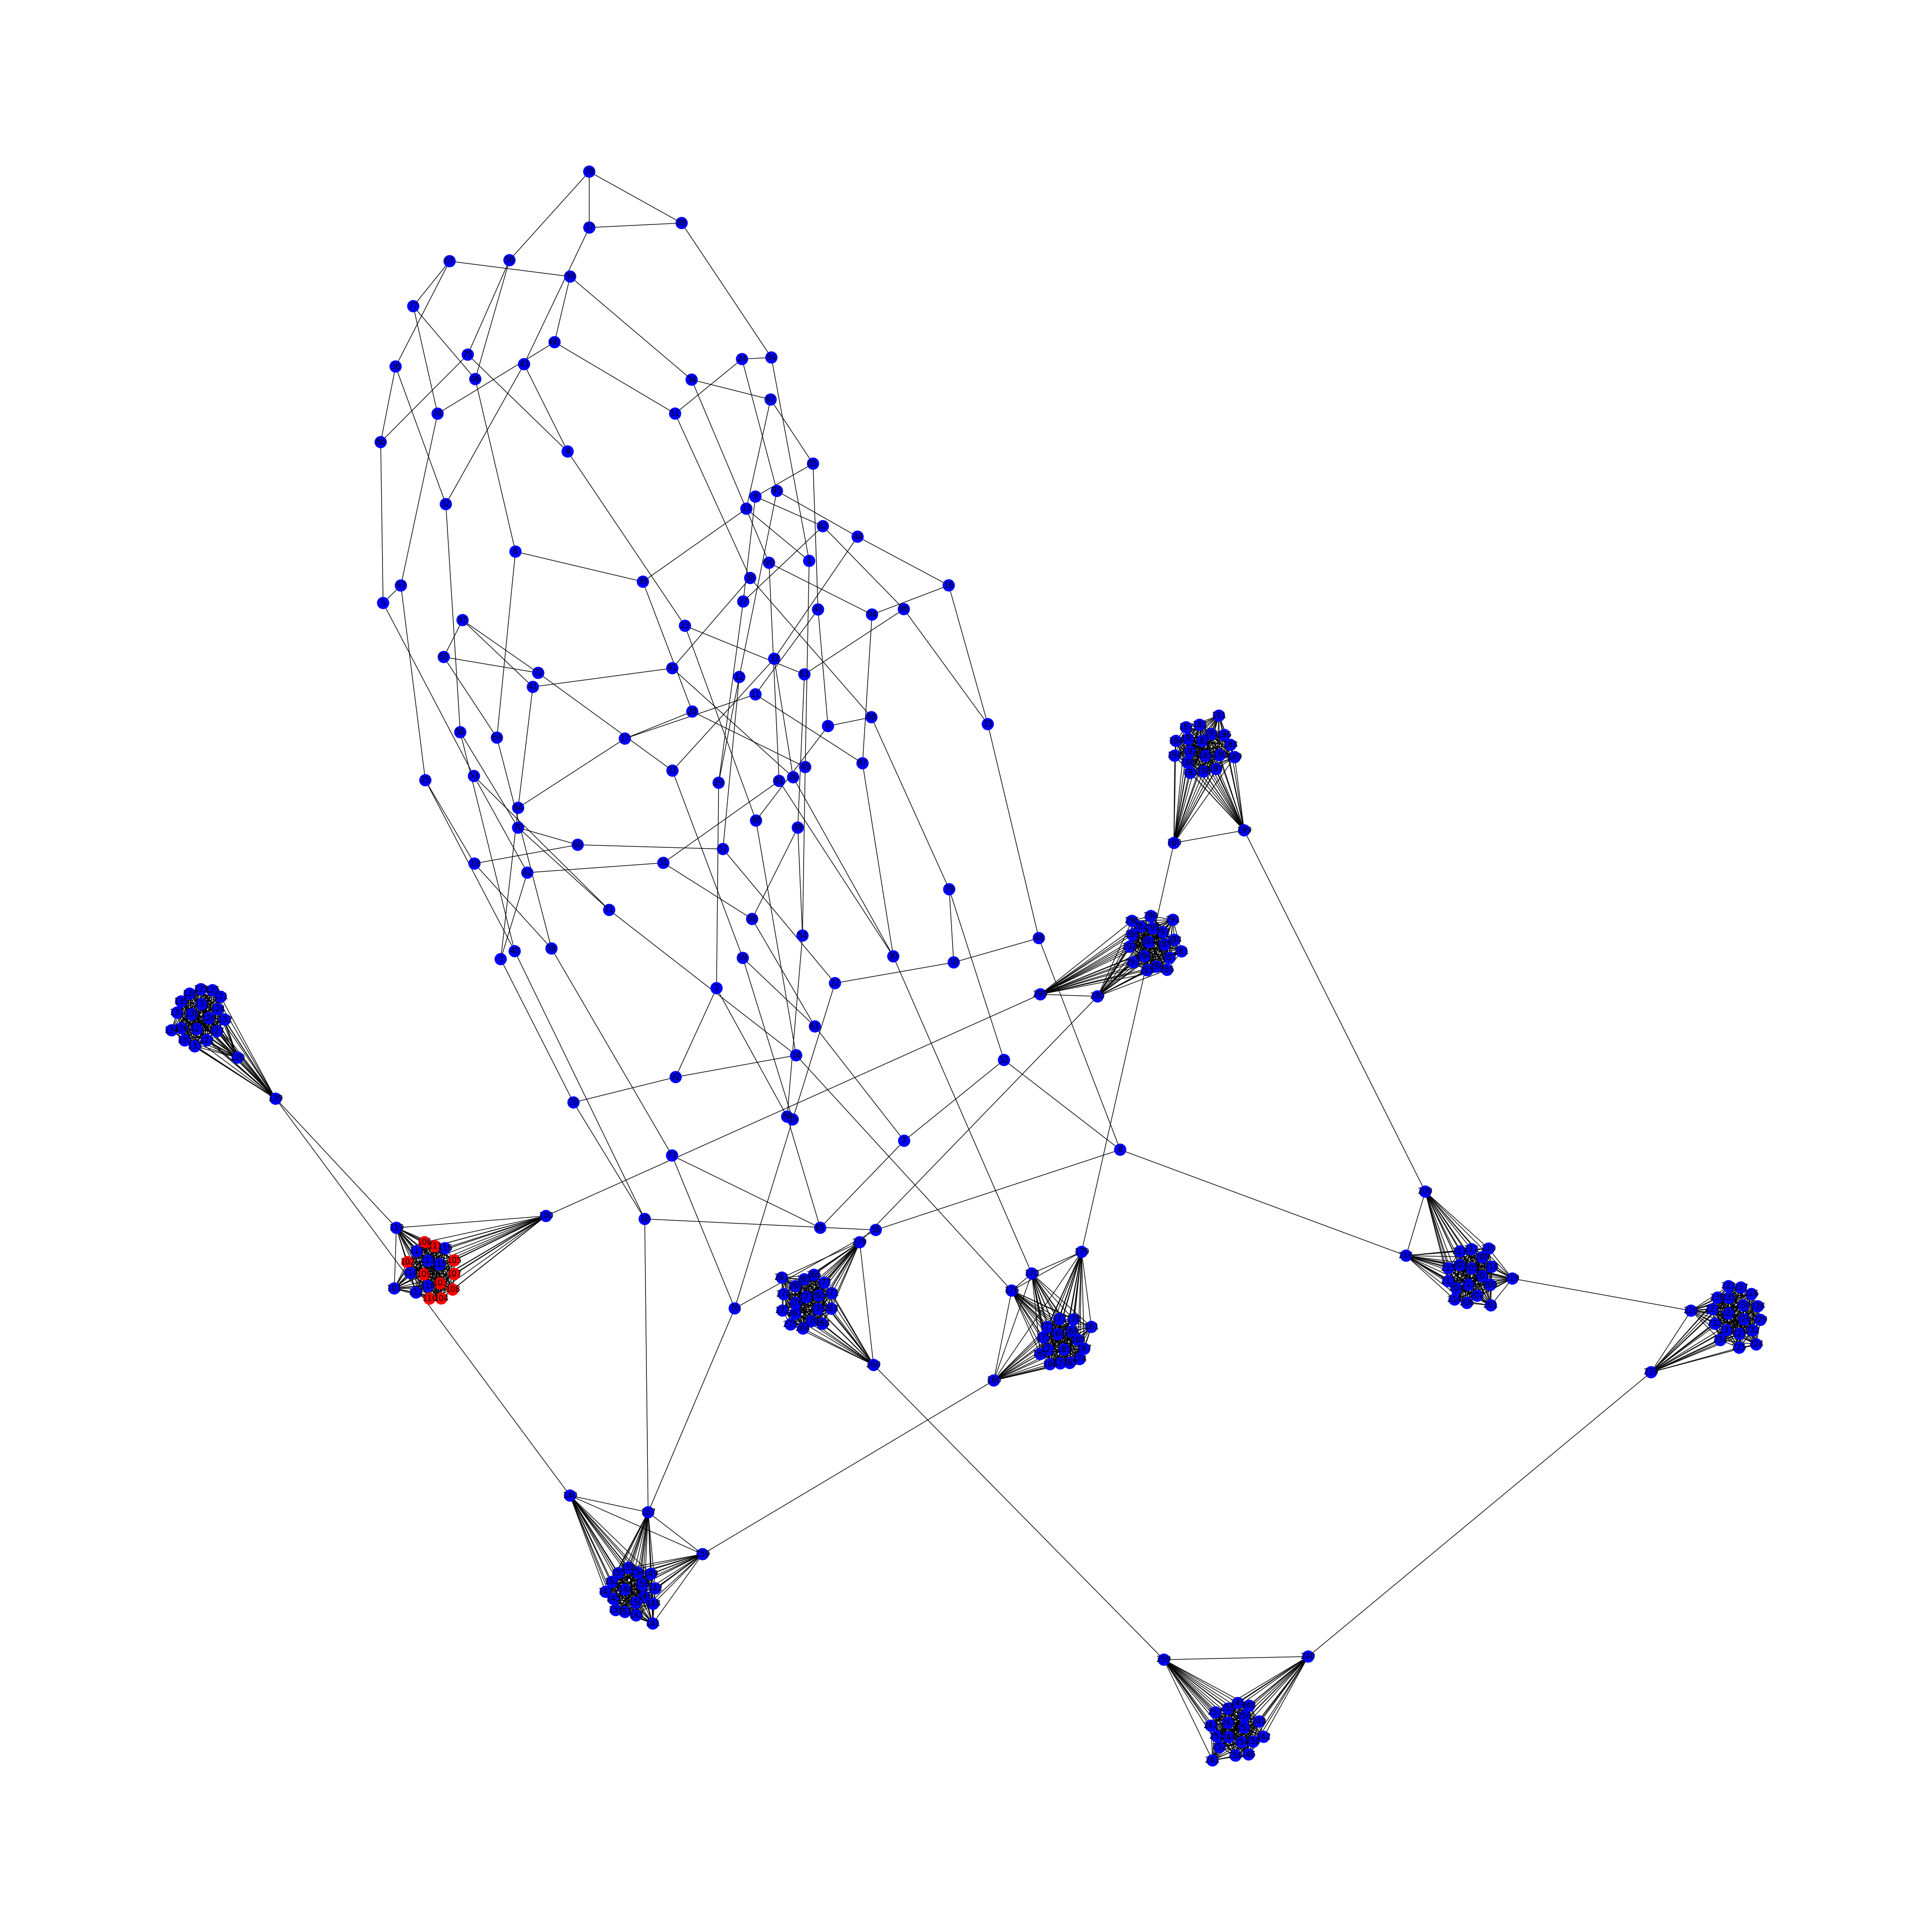

In [6]:
#Ex 2.1
import random
G1 = nx.random_regular_graph(d=3, n=100, seed=42)
G2 = nx.connected_caveman_graph(10, 20)

for edge in G1.edges():
    G1[edge[0]][edge[1]]["weight"] = 1

for edge in G2.edges():
    G2[edge[0]][edge[1]]["weight"] = 1

G_merged = nx.disjoint_union(G1, G2)
"""
for edge in G_merged.edges():
    if "weight" not in G_merged[edge[0]][edge[1]]:
        G_merged[edge[0]][edge[1]]["weight"] = 1
"""
for _ in range(5):
    u = random.randint(0, 99)
    v = random.randint(100, 299)
    G_merged.add_edge(u, v,weight=1)


compute_egonet_features(G_merged)
regresie(G_merged)


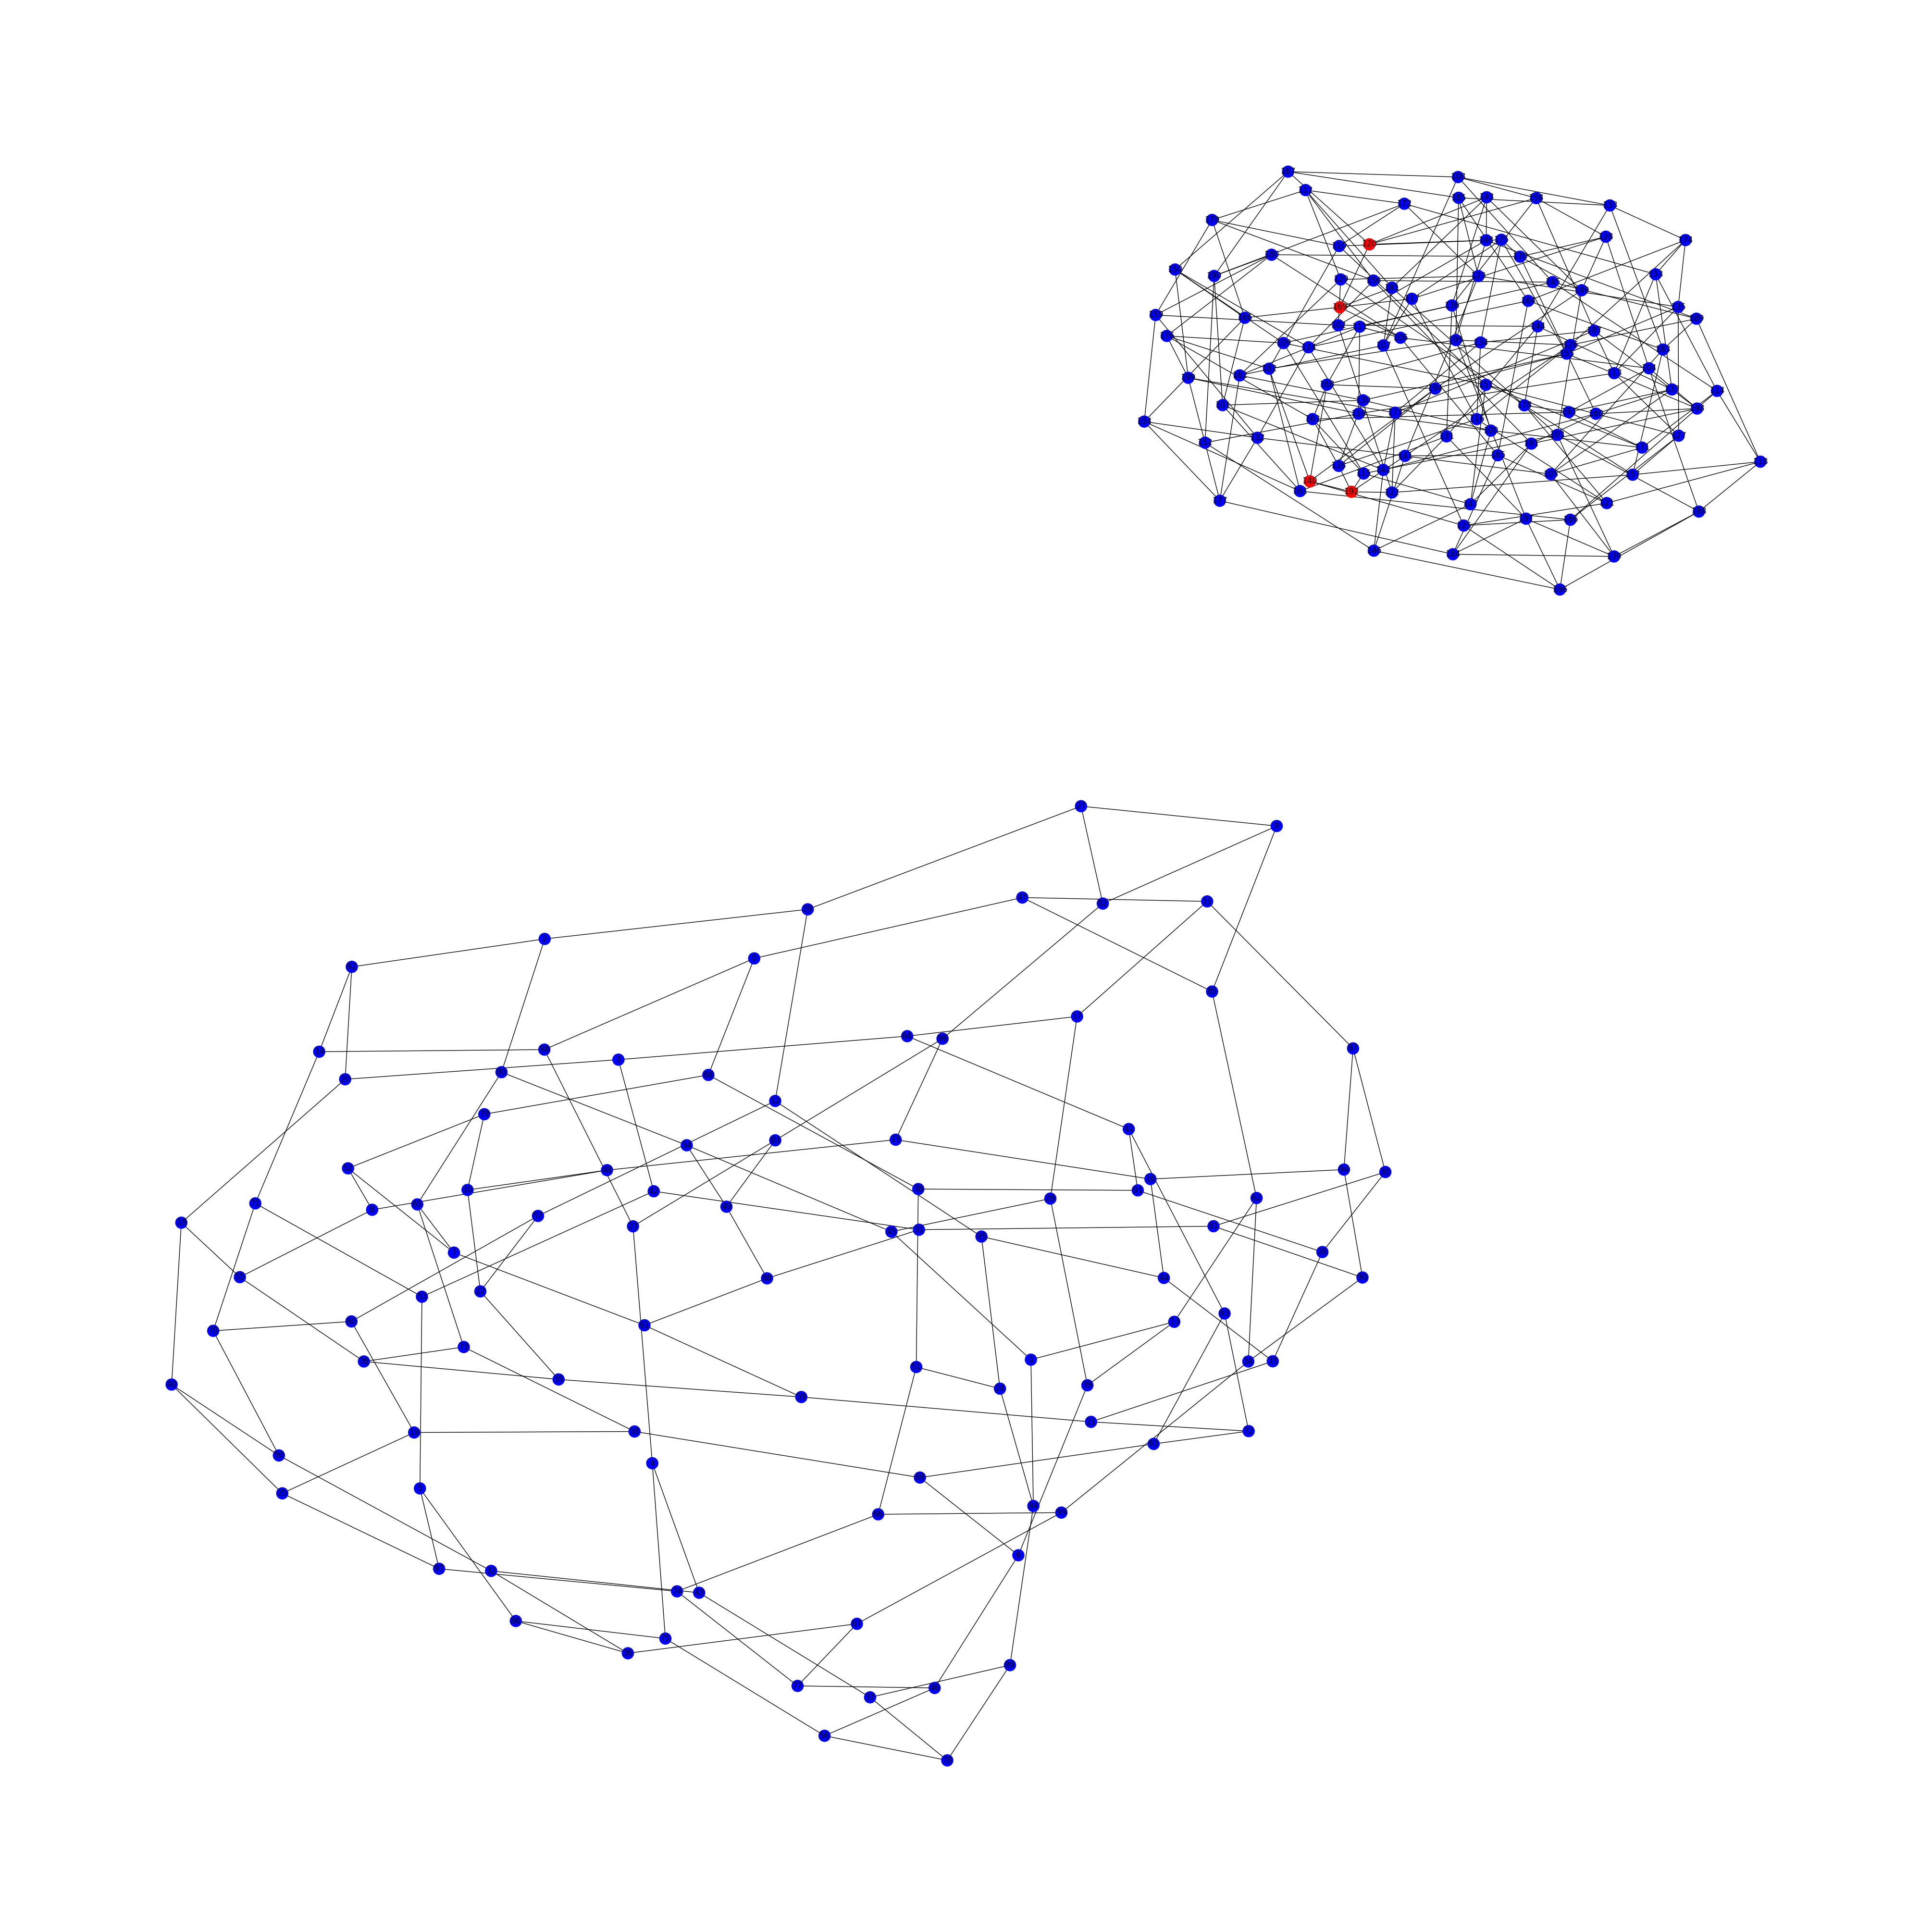

In [9]:
#Ex 2.2
G1 = nx.random_regular_graph(d=3, n=100, seed=42)
G2 = nx.random_regular_graph(d=5, n=100, seed=42)

G_merged = nx.disjoint_union(G1, G2)
for edge in G_merged.edges():
    if "weight" not in G_merged[edge[0]][edge[1]]:
        G_merged.add_edge(edge[0],edge[1],weight=1)

#2 random nodes
random_nodes = random.sample(list(G_merged.nodes()), 2)

for node in random_nodes:
    neighbors = list(G_merged.neighbors(node))
    subgraph_nodes = [node] + neighbors

    for (a, b) in G_merged.subgraph(subgraph_nodes).edges():
        G_merged[a][b]["weight"] += 10


compute_egonet_features(G_merged)

regresie(G_merged,feat1="W",feat2="E",nr_outlier=4)

In [27]:
#Ex 3.1-2
data_mat = loadmat('ACM.mat')


adj_matrix  = data_mat['Network']      # shape: [num_nodes, num_nodes]
attributes  = data_mat['Attributes']   # shape: [num_nodes, num_features]
labels      = data_mat['Label']        # shape: [num_nodes, 1] (or similar)

edge_index, edge_weight = from_scipy_sparse_matrix(adj_matrix)




In [24]:
#Ex 3.3


class Encoder(nn.Module):
    """
      GCNConv 1: in_features -> 128, activation ReLU
      GCNConv 2: 128 -> 64 , activation ReLU
    """
    def __init__(self, in_channels, hidden1=128, hidden2=64):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden1)
        self.conv2 = GCNConv(hidden1, hidden2)

    def forward(self, x, edge_index):
        # Layer 1
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        # Layer 2
        x = self.conv2(x, edge_index)
        z = F.relu(x)
        return x  # latent representation Z


class AttributeDecoder(nn.Module):
    """
      GCNConv 1: 64 -> 128, activation ReLU
      GCNConv 2: 128 -> out_features, ReLU
    """
    def __init__(self, latent_dim=64, hidden1=128, out_channels=None):
        super().__init__()
        self.conv1 = GCNConv(latent_dim, hidden1)
        # out_channels is typically your original feature dimension
        self.conv2 = GCNConv(hidden1, out_channels)

    def forward(self, z, edge_index):
        # Layer 1
        x_hat = self.conv1(z, edge_index)
        x_hat = F.relu(x_hat)
        # Layer 2
        x_hat = self.conv2(x_hat, edge_index)

        x_hat = F.relu(x_hat)
        return x_hat


class StructureDecoder(nn.Module):
    """
      - 1 GCNConv: 64 -> 64, activation ReLU
    """
    def __init__(self, latent_dim=64):
        super().__init__()
        self.conv = GCNConv(latent_dim, latent_dim)

    def forward(self, z, edge_index):

        z_struct = self.conv(z, edge_index)
        z_struct = F.relu(z_struct)

        # Reconstruct adjacency as matrix product
        # (batch_size, 64) x (64, batch_size) = (batch_size, batch_size)
        A_hat = torch.matmul(z_struct, z_struct.t())

        return A_hat


class GraphAutoEncoder(nn.Module):
    def __init__(self, in_channels, hidden1=128, hidden2=64):
        super().__init__()
        self.encoder = Encoder(
            in_channels=in_channels,
            hidden1=hidden1,
            hidden2=hidden2
        )
        self.decoder_attr = AttributeDecoder(
            latent_dim=hidden2,
            hidden1=hidden1,
            out_channels=in_channels  # typically reconstruct to original input dimension
        )
        self.decoder_struct = StructureDecoder(latent_dim=hidden2)

    def forward(self, x, edge_index):
        # 1) Encode
        z = self.encoder(x, edge_index)

        # 2) Decode attributes
        x_hat = self.decoder_attr(z, edge_index)

        # 3) Decode structure
        A_hat = self.decoder_struct(z, edge_index)

        # Return both reconstructions
        return x_hat, A_hat


in_channels = attributes.shape[1]

# Instantiate the GAE
model = GraphAutoEncoder(in_channels=in_channels)


In [25]:
#Ex 3.4

def myLoss(X, X_hat, A, A_hat, alpha=0.8):
    loss_attr = torch.norm(X - X_hat, p='fro') ** 2
    loss_struct = torch.norm(A - A_hat, p='fro') ** 2

    return alpha * loss_attr + (1 - alpha) * loss_struct



I run out of memory on this notebook, but I think the code should work for smaller graphs


In [ ]:
#Ex 3.5



learning_rate = 0.004
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 25

x=attributes
x_dense = attributes.todense()  # or attributes.toarray()
x = torch.tensor(x_dense, dtype=torch.float)
print(type(x))


A_np = adj_matrix.todense()
A = torch.tensor(A_np, dtype=torch.float)


def get_node_errors(x, x_hat, A, A_hat):

    # Attribute error: (N, in_features)
    attr_errors = (x_hat - x).pow(2).mean(dim=1)  # mean over features => shape (N,)

    # Structure error: row-wise MSE => shape (N,)
    struct_errors = (A_hat - A).pow(2).mean(dim=1)  # mean over columns

    # Combine them
    return attr_errors + struct_errors

for epoch in range(1, num_epochs + 1):
    model.train()           # set to training mode
    optimizer.zero_grad()   # reset gradients

    # Forward pass
    x_hat, A_hat = model(x, edge_index)
    #print(A_hat.shape)

    loss = myLoss(x, x_hat, A, A_hat)

    # Backprop and update
    loss.backward()
    optimizer.step()


    if epoch % 2 == 0:
        print(f"Epoch {epoch:02d} | Loss: {loss.item():.4f}")


    if epoch % 5 == 0:
        model.eval()
        with torch.no_grad():
            x_hat_eval, A_hat_eval, _ = model(x, edge_index)


        node_errors = get_node_errors(x, x_hat_eval, A, A_hat_eval)
        node_errors = node_errors.cpu().numpy()


        labels_np = labels.cpu().numpy()

        # ROC AUC
        auc_value = roc_auc_score(labels_np, node_errors)

        print(f"[Epoch {epoch:02d}] ROC AUC: {auc_value:.4f}")

<class 'torch.Tensor'>
